<a href="https://colab.research.google.com/github/Marel88/Bioinfo_7_1/blob/master/Bio_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install py_wsi --no-index --find-links file:///Users/Mac/Desktop/py-wsi-1.1.zip
!apt install openslide-tool
!pip install openslide-python

#SCRIPT FOR IMAGE CROPPING


import py_wsi
import py_wsi.imagepy_toolkit as tk
from py_wsi import turtle

file_dir = "/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Healthy/"
db_location = "/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Healthy_patches/"
xml_dir = file_dir
patch_size = 64
level = 10
db_name = ""
overlap = 0

# All possible labels mapped to integer ids in order of increasing severity.
label_map = {}

turtle = turtle.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='disk')
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=False, limit_bounds=True)


In [2]:
#CNN BASE MODEL

import numpy as np
!pip3 install keras
!pip3 install tensorflow==1.5.0
!pip install mxnet-mkl
!pip install sklearn
!pip3 install keras_tqdm
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
train_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Patches/"
valid_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Validation/Patches"
test_path ="/Users/Mac/Desktop/ROI-dataset-bioinf/Test/Patches"

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(64,64), classes=['Benign', 'Healthy', 'Cancer'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(64,64), classes=['Benign', 'Healthy', 'Cancer'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(64,64), classes=['Benign', 'Healthy', 'Cancer'], batch_size=10)

Found 4084 images belonging to 3 classes.
Found 2733 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [0]:
#For plotting images with labels
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
  if type (ims[0]) is np.ndarray:
    ins = np.array(ims).astype(np.uint8)
    if (ims.shape[-1] != 3):
        ims = ims.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  cols = len(ins)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
  for i in range(len(ims)):
      sp = f.add_subplot(rows,cols,i+1)
      sp.axis('Off')
      if titles is not None:
          sp.set_title(titles[i],fontsize=16)
      plt.imshow(ims[i], interpolation=None if interp else 'none')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

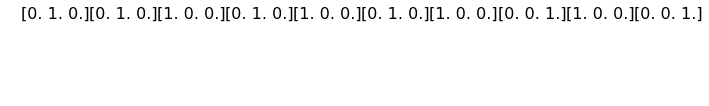

In [16]:
imgs, labels = next(train_batches)

plots(imgs,titles=labels)